# 3. Model tests
## 3.05 Example: Time delay neural network


Testing the time-delay neural network involves following steps:
1. Load the predictor and predictand arrays (these have been prepared in `2.05_prepare_data_for_the_models`)
3. Define the ML-model
4. Train the model
5. Check the output for errors by visually inspecting timeseries of forecasts.
6. Hyperparameter Optimization
7. Case Study: May/June 2013; Flooding event at Krems (Danube river)
   
   

In [1]:
import sys
sys.path.append("../../")
import numpy as np
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd
import seaborn as sns
import xarray as xr
import keras

from python.aux.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
from python.aux.plot import plot_multif_prediction

Using TensorFlow backend.
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

## Loading the data
We now load Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [12]:
# load data
ds = xr.open_dataset('../../data/features_xy.nc')

y_orig = ds['dis']
y = y_orig.copy()
X = ds #.drop(['dis', 'dis_diff', 'lsp-56-180'])


In [13]:
X

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

### Differentiating the predictand
xyz
Predicting just time differences of discharge is the natural way yields a nicer distribution of the predictand so that we can use Mean-Squared-Error as optimization metric. 

mean: 0.0 , std: 269074.8916842176 , skew: 167850422.6997186


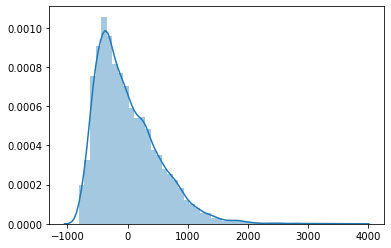

In [14]:
from scipy.stats import moment
dist = y.values.ravel() - y.mean().values.ravel() 
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

mean: 0.0 , std: 4181.27897581471 , skew: 1100883.0967652714


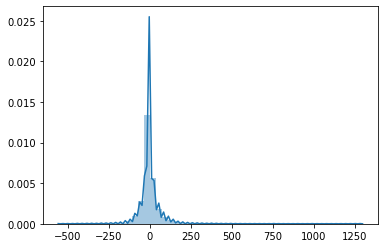

In [15]:
from scipy.stats import moment
dist = y.diff('time', n=1).values.ravel()
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [16]:
y = y.diff('time', 1)
y

<xarray.DataArray 'dis' (time: 13513)>
array([-6.15387 ,  4.498413, 17.529724, ..., -4.656921, -2.809204, 20.632019])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-02 1981-01-03 ... 2017-12-31

### Reshaping


In [17]:
from python.aux.utils_floodmodel import reshape_scalar_predictand

In [18]:
Xda, yda = reshape_scalar_predictand(X, y)
Xda.features

<xarray.DataArray 'features' (features: 18)>
array([('cp',), ('lsp',), ('swvl1',), ('ro',), ('sd',), ('sd_diff',),
       ('lsp-4-11',), ('lsp-12-25',), ('lsp-26-55',), ('lsp-56-180',),
       ('lsp-1',), ('lsp-2',), ('lsp-3',), ('cp-1',), ('cp-2',), ('cp-3',),
       ('dis',), ('dis_diff',)], dtype=object)
Coordinates:
  * features  (features) object ('cp',) ('lsp',) ... ('dis',) ('dis_diff',)

---

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [19]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2017'))

In [20]:
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [21]:
X_train.shape, y_train.shape

((8922, 18), (8922,))

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers.core import Dropout
from keras.constraints import MinMaxNorm, nonneg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.output_dim = kwargs.pop('output_dim', 1)
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        
        model = keras.models.Sequential()
        self.cfg = kwargs
        hidden_nodes = self.cfg.get('hidden_nodes')
        
        model.add(keras.layers.Dense(hidden_nodes[0], 
                                     activation='tanh'))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in hidden_nodes[1:]:
            model.add(keras.layers.Dense(n, activation='tanh')) 
            model.add(keras.layers.BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(keras.layers.Dense(self.output_dim, 
                                     activation='linear'))
        opt = keras.optimizers.Adam() 

        model.compile(loss=self.cfg.get('loss'), optimizer=opt)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the Nash-Sutcliff-Efficiency"""
        ypred = self.predict(X).values
        err_pred = ypred - y
        err_mean = np.nanmean(y)-y
        nse = 1-np.dot(err_pred, err_pred)/np.dot(err_mean, err_mean)
        return float(nse)
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        initial_dis : xr.DataArray
            of shape (init_time,), defines the initial discharge for each sample in `Xda`
        """
        X = self.xscaler.transform(Xda.values)
        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        
        y = add_time(y, Xda.time, name=name)
        return y

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """Input: xr.DataArray"""
        
        print(X_train.shape)
        X_train = self.xscaler.fit_transform(X_train.values)
        y_train = self.yscaler.fit_transform(
                        y_train.values.reshape(-1, self.output_dim))
        
        X_valid = self.xscaler.transform(X_valid.values)
        y_valid = self.yscaler.transform(
                        y_valid.values.reshape(-1, self.output_dim))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.cfg.get('epochs', 1000),
                              batch_size=self.cfg.get('batch_size'),
                              callbacks=self.callbacks,
                              verbose=0, **kwargs)

In [23]:
config = dict(hidden_nodes=(80,),  
                dropout=0.4,
                epochs=300,
                batch_size=90,
                loss='mse')

m = DenseNN(**config)

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
hist = m.fit(X_train, y_train, X_valid, y_valid)

(8922, 18)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [25]:
m.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                1520      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 1,921
Trainable params: 1,761
Non-trainable params: 160
_________________________________________________________________


To plot a graph of the network, run the following cell:

The learning curve describes how quickly the optimization of the neural net's parameters converges or if it does not converge at all. The blue line measures the training error and the orange line the validation error. If, at some point, training error but not validation error sinks, the model is overfitting on the training set. 

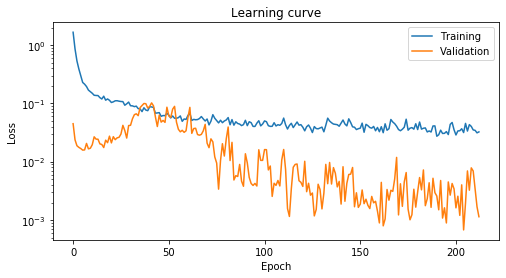

In [26]:
h = hist.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [27]:
import os, yaml
dir_model = '../../models/tdnn-diff-batch90-25yrs/'
os.makedirs(dir_model, exist_ok=True)

In [28]:
y_pred_train = m.predict(X_train)
y_pred_train = generate_prediction_array(y_pred_train, y_orig, forecast_range=14)

y_pred_valid = m.predict(X_valid)
y_pred_valid = generate_prediction_array(y_pred_valid, y_orig, forecast_range=14)

y_pred_test = m.predict(X_test)
y_pred_test = generate_prediction_array(y_pred_test, y_orig, forecast_range=14)

In [29]:
from python.aux.utils_floodmodel import multi_forecast_case_study_tdnn

In [79]:
X_multif_fin, X_multifr_fin, y_case_fin = multi_forecast_case_study_tdnn(m)

In [80]:
X_multif_fin

<xarray.DataArray 'prediction' (num_of_forecast: 4, time: 42)>
array([[1838.148315, 1806.850708, 1783.335938, 1747.927124, 1736.585938,
        1728.758057, 1730.989624, 1740.761963, 1760.619263, 1795.824219,
        1836.384399, 1866.275391, 1877.622681, 1927.067139, 2508.528809,
        3909.679443, 4594.492676, 4995.527344, 4912.134766, 4674.402832,
        4406.932617, 4143.852051, 3885.675781, 3695.283691, 3683.047119,
        3757.759521, 3782.081787, 3739.926758, 3679.545898, 3630.048584,
        3585.200439,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan],
       [        nan,         nan,         nan,         nan, 1863.230103,
        1855.402222, 1857.633789, 1867.406128, 1887.263428, 1922.468384,
        1963.028564, 1992.919556, 2004.266846, 2053.711182, 2635.172852,
        4036.323486, 4721.136719, 5122.171387, 5038.778809, 4801.046875,
        4533.57666 , 4270.

In [81]:
y_pred_valid.to_netcdf(dir_model+'tdnn_result_validation_period.nc')
y_pred_test.to_netcdf(dir_model+'tdnn_result_test_period.nc')
X_multif_fin.to_netcdf(dir_model+'tdnn_result_case_study.nc')

In [83]:
yaml_string = m.model.to_yaml()
with open(dir_model+'keras-config.yml', 'w') as f:
    yaml.dump(yaml_string, f)
    
with open(dir_model+'model-config.yml', 'w') as f:
    yaml.dump(config, f, indent=4)
    
from contextlib import redirect_stdout
with open(dir_model+'summary.txt', "w") as f:
    with redirect_stdout(f):
        m.model.summary()

In [30]:
from python.aux.plot import plot_multif_prediction
true_dis = y_orig

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59380ae0f0>)

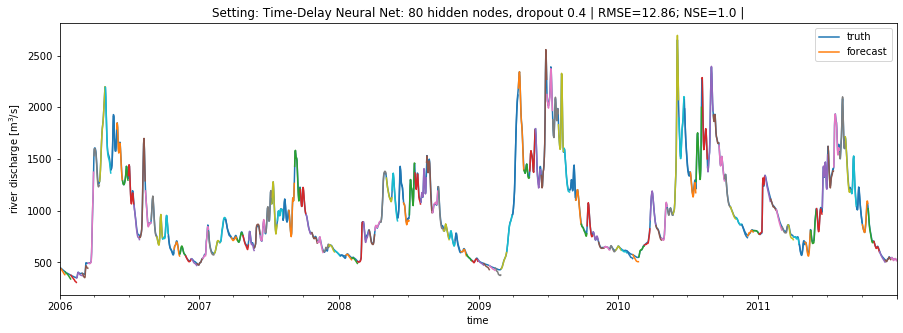

In [31]:
title='Setting: Time-Delay Neural Net: 80 hidden nodes, dropout 0.4'
plot_multif_prediction(y_pred_valid, y_orig, forecast_range=14, title=title)

## Feature importance

To see the contribution of the features to the final prediction, we can compare the model performance with and without the information from some feature by shuffling the rows of the `X` matrix for that feature, that is, the feature is randomized in a way that maintains the true feature value distribution.

This allows us to evaluate the impact of a feature on the model performance without training the model for each feature over and over again. 

In [ ]:
import eli5
from eli5.permutation_importance import get_score_importances

In [ ]:
from python.aux.verification import RMSE
m.score_func(X_test, y_test)

base_score, RMSE_improvement = get_score_importances(m.score_func, X_test, y_test, n_iter=3)

In [ ]:
#  feature_importances = np.mean(score_decreases, axis=0)

In [ ]:
def feature_importance_plot(xda_features, score_decreases):
    # xda_features : xr.DataArray.features
    # score_decreases : list of arrays
    
    labels = [e[0] for e in xda_features.values]
    assert len(labels) == len(score_decreases[0])  # one label per entry
    n_iter = len(score_decreases)
    width = 1/n_iter
    plt.subplots(figsize=(20,5))

    for c in range(n_iter):
        x = np.arange(len(labels))+c/n_iter
        plt.bar(x, score_decreases[c], width=-width, align='edge')

    plt.grid()
    plt.xticks(ticks=x, labels=labels, rotation=45)
    plt.ylabel('discharge RMSE')

In [ ]:
feature_importance_plot(Xda.features, RMSE_improvement)

The importance values are in units of our predictand (discharge) in m$^3$/s. There are some concerns about the validity of the results from this library, so follow the [ELI5-discussion on github](https://github.com/TeamHG-Memex/eli5/issues/316). Negative values in this diagram mean that those features result in a worsening of the RMS error.



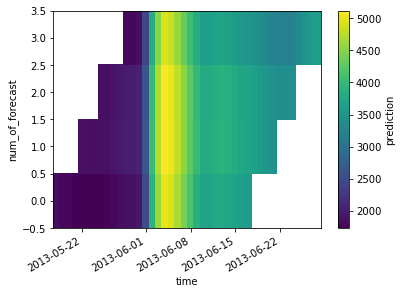

In [88]:
X_multif_fin.plot()

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5b9c0b7860>)

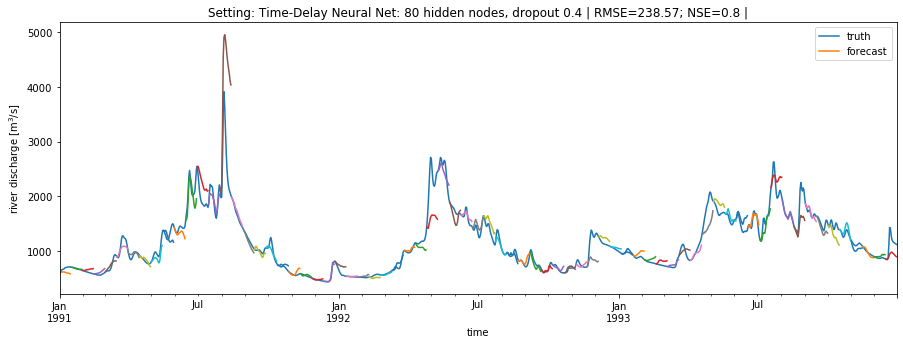

In [89]:
from python.aux.plot import plot_multif_prediction

title='Setting: Time-Delay Neural Net: 80 hidden nodes, dropout 0.4'
plot_multif_prediction(y_pred_valid, y_orig, forecast_range=14, title=title)

In [90]:
df = pd.read_csv('tdnn-hyperparams2.txt', sep=';', header=0)
df.sort_values('rmse')

,hidden_nodes,dropout,output_dim,epochs,batch_size,loss,rmse,seconds
23,"(80,)",0.4,1,300,90,mse,1522.235255,92
41,"(65,)",0.4,1,300,90,mse,1525.494847,167
22,"(64,)",0.4,1,300,90,mse,1526.686985,84
15,"(64,)",0.2,1,300,90,mse,1528.454726,93
39,"(128,)",0.5,1,300,90,mse,1532.023644,151
9,"(80,)",0.1,1,300,90,mse,1537.137282,76
38,"(100,)",0.5,1,300,90,mse,1538.726053,168
16,"(80,)",0.2,1,300,90,mse,1539.316254,75
40,"(110,)",0.5,1,300,90,mse,1540.486584,174
30,"(80,)",0.5,1,300,90,mse,1544.263087,121
